In [1]:
# Backtesting strategy - IV : combining renko with other MACD


In [9]:
import numpy as np
import pandas as pd 
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import copy
import configparser
import time

In [6]:
# Loading keys from config parser
config = configparser.ConfigParser()
config.read_file(open('/home/venom/GitHub/cheatsheets/courses/Udemy/course11/secret.cfg'))

In [7]:
KEY = config.get('ALPHA_VANTAGE', 'KEY')

In [14]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [ ]:
# Download historical data for DJI constituent stocks

tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]


ohlc_intraday = {} # directory with ohlc value for each stock            
key_path = "D:\\Udemy\\Quantitative Investing Using Python\\1_Getting Data\\AlphaVantage\\key.txt"
ts = TimeSeries(key=open(key_path,'r').read(), output_format='pandas')

attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <=5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i],interval='5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ["Open","High","Low","Adj Close","Volume"]
            drop.append(tickers[i])      
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1

 
tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data


In [10]:
# Download historical data (monthly) for selected stocks

tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]
ts = TimeSeries(key=KEY, output_format='pandas')

ohlc_intraday = {} # directory with ohlc value for each stock   
api_call_count = 1
ts = TimeSeries(key=KEY, output_format='pandas')
start_time = time.time()
for ticker in tickers:
    data = ts.get_intraday(symbol=ticker,interval='5min', outputsize='full')[0]
    api_call_count+=1
    data.columns = ["Open","High","Low","Adj Close","Volume"]
    data = data.iloc[::-1]
    data = data.between_time('09:35', '16:00') #remove data outside regular trading hours
    ohlc_intraday[ticker] = data
    if api_call_count==5:
        api_call_count = 1
        time.sleep(60 - ((time.time() - start_time) % 60.0))

tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data

In [12]:
# ohlc_intraday

In [15]:
#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["macd"]= MACD(ohlc_renko[ticker],12,26,9)[0]
    ohlc_renko[ticker]["macd_sig"]= MACD(ohlc_renko[ticker],12,26,9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

       
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
                elif ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])


merging for  MSFT


/home/venom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/venom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


merging for  AAPL
merging for  FB
merging for  AMZN
merging for  INTC
merging for  CSCO
merging for  VZ
merging for  IBM
merging for  QCOM
merging for  LYFT
calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  FB
calculating daily returns for  AMZN
calculating daily returns for  INTC
calculating daily returns for  CSCO
calculating daily returns for  VZ
calculating daily returns for  IBM
calculating daily returns for  QCOM
calculating daily returns for  LYFT


In [16]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))  


-0.0934822010866887
-1.3776178393436236
0.025451314421047765


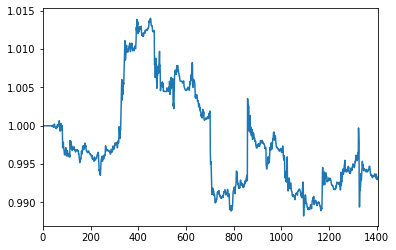

In [18]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [19]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  QCOM
calculating KPIs for  LYFT


,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.316287,-1.940738,0.065709
AAPL,0.836695,4.317256,0.035172
FB,-0.374479,-1.668422,0.070359
AMZN,-0.303196,-1.907442,0.060511
INTC,4.665224,9.046646,0.079209
CSCO,-0.532488,-4.853238,0.060537
VZ,-0.230590,-3.894351,0.022781
IBM,0.284488,2.327732,0.027905
QCOM,0.642927,2.912105,0.070090
LYFT,-0.874840,-3.376126,0.172695
